In [54]:
#Set up data_holder class
import pandas as pd
from collections import namedtuple
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

class data_holder():
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
        self.df = self.data.copy()

    def basic_eda(self):
        # count the number of duplicated rows, then grab all NaN (i.e., null) rows
        # in the dataframe
        num_duplicated = self.df.duplicated().sum()
        is_nan = self.df.isnull()
        
        # count the total number of rows that contain *at least one* null value
        num_null_rows = is_nan.any(axis=1).sum()
        
        # count the total number of null values across *all* rows and *all* columns
        # (i.e., a sum of a sum)
        num_total_null = self.df.isnull().sum().sum()

        # construct a named tuple to represent each row in the exploratory data
        # analysis summary
        EDARow = namedtuple("EDARow", ["Name", "Value", "Notes"])

            # build the list of exploratory data analysis rows
        rows = [
            EDARow("Samples", self.df.shape[0], ""),
            EDARow("Features", self.df.shape[1], ""),
            EDARow("Duplicate Rows", num_duplicated, ""),
            EDARow("Rows with NaN", num_null_rows, "{:.2f}% all rows".format(
                (num_null_rows / self.df.shape[0]) * 100)),
            EDARow("Total NaNs", num_total_null, "{:.2f}% feature matrix".format(
                (num_total_null / (self.df.shape[0] * self.df.shape[1])) * 100)),
        ]
            
        # build and return our exploratory data analysis dataframe
        return pd.DataFrame(rows, columns=["Name", "Value", "Notes"])

    def summarize_data(self):
        # initialize a summary dataframe consiting of the original dataframe's
        # column names and data types
        summary = pd.DataFrame(self.df.dtypes, columns=["dtypes"])
        
        # reset the summary index, rename the "index" column to "Name", and then
        # remove the "index" column
        summary = summary.reset_index()
        summary["Name"] = summary["index"]
        summary = summary[["Name", "dtypes"]]
        
        # count the number of (1) null values for each column, and (2) the unique
        # values in each column
        summary["Missing"] = self.df.isnull().sum().values
        summary["Uniques"] = self.df.nunique().values
        
        # return the summary dataframe
        return summary



# Some initial exploratory data analysis (eda) to get to know the dataset. 
On Kaggle, there are two data sets, one with data going back to 1900, and one only from 1970. At a quick glance:

In [106]:
disasters_1970 = data_holder('./DISASTERS/1970-2021_DISASTERS.xlsx - emdat data.csv')

overview_1970 = disasters_1970.basic_eda()
overview_1970.head()

,Name,Value,Notes
0,Samples,14644,
1,Features,47,
2,Duplicate Rows,0,
3,Rows with NaN,14644,100.00% all rows
4,Total NaNs,308558,44.83% feature matrix


In [135]:
disasters_1900 = data_holder('./DISASTERS/1900_2021_DISASTERS.xlsx - emdat data.csv')

overview_1900 = disasters_1900.basic_eda()
overview_1900.head()

,Name,Value,Notes
0,Samples,16126,
1,Features,45,
2,Duplicate Rows,0,
3,Rows with NaN,16126,100.00% all rows
4,Total NaNs,329417,45.39% feature matrix


The 1970s data set has 2 more features than the 1900-one, but the latter has 1482 more samples. None of the data sets contain duplicate rows, but _all_ rows have NaN-values.

What are the two features added to the 1970-set?

In [127]:
features_1900 = list(disasters_1900.data.columns)
features_1970 = list(disasters_1970.data.columns)

only_in_1900 = [col for col in features_1900 if col not in features_1970]
only_in_1970 = [col for col in features_1970 if col not in features_1900]

# Print the results
print("Columns only in 1900 dataset:")
print(only_in_1900)

print("\nColumns only in 1970 dataset:")
print(only_in_1970)

Columns only in 1900 dataset:
[]

Columns only in 1970 dataset:
['Dis No', "Reconstruction Costs ('000 US$)"]


Only the 1970-data has reconstruction cost. As I am probably interested in the cost after the damages it might be relevant to look at only the 1970-set, but before I decide I want to see how many samples there are in the three cost-features:
- Reconstruction Costs ('000 US$)
- Insured Damages ('000 US$)
- Total Damages ('000 US$)

In [175]:
def unique_non_null_values_in_feature(input, feature):
    feature_rows = input.data[input.data[feature].notna()]
    unique_rows = feature_rows.drop_duplicates(subset=[col for col in feature_rows.columns if col != "ID"])

    return unique_rows


In [183]:
#Start with 1900 as it has the most values

unique_insured = unique_non_null_values_in_feature(disasters_1900, "Insured Damages ('000 US$)")
unique_total = unique_non_null_values_in_feature(disasters_1900, "Total Damages ('000 US$)")

print("Rows with non-null values (excluding duplicates) (1900):")
print(f"Insurance costs: {unique_insured.shape[0]}")
print(f"Total damages: {unique_total.shape[0]}")


Rows with non-null values (excluding duplicates) (1900):
Insurance costs: 1096
Total damages: 5245


In [184]:
#And now 1970:

unique_recon = unique_non_null_values_in_feature(disasters_1970, "Reconstruction Costs ('000 US$)")
unique_insured = unique_non_null_values_in_feature(disasters_1970, "Insured Damages ('000 US$)")
unique_total = unique_non_null_values_in_feature(disasters_1970, "Total Damages ('000 US$)")


print("Rows with non-null values (excluding duplicates): (1970)")
print(f"Reconstruction costs: {unique_recon.shape[0]}")
print(f"Insurance costs: {unique_insured.shape[0]}")
print(f"Total damages: {unique_total.shape[0]}")

Rows with non-null values (excluding duplicates): (1970)
Reconstruction costs: 31
Insurance costs: 1094
Total damages: 4863


The above quick analysis shows some more samples in the 1900-set but the difference is not monumental. On the other hand, only 31 samples actually have the reconstruction cost so working with the 1900-set might on the whole be enough.

Time to look more closely into the sub groups of these natural disasters. If the point of the analysis will be to look into disasters possibly related to climate change, then geophysical disasters do not sound relevant.

In [188]:
# define the disaster type columns we are interested then
disaster_cols = [
    "Disaster Subgroup",
    "Disaster Type",
    "Disaster Subtype",
    "Disaster Subsubtype",
]

# grab the disaster data from the dataframe
disaster_df = disasters_1900.df[disaster_cols]

# fill any null values with an empty string (implying that no subgroups or
# subtypes exist for the current value)
disaster_df = disaster_df.fillna(value={
    "Disaster Subtype": "NA",
    "Disaster Subsubtype": "NA",
})

# construct the final dataframe which displays a hierarchical overview of the
# disaster types, including the counts for each one
disaster_df = pd.DataFrame(
    disaster_df.groupby(disaster_cols).size().to_frame("count")
)

disaster_df

count
Disaster Subgroup Disaster Type         Disaster Subtype                 Disaster Subsubtype           
Biological        Animal accident       NA                               NA                           1
                  Epidemic              Bacterial disease                NA                         768
                                        NA                               NA                         141
                                        Parasitic disease                NA                          49
                                        Viral disease                    NA                         543
                  Insect infestation    Grasshopper                      NA                          16
                                        Locust                           NA                          62
                                        NA                               NA                          18
Climatological    Drought               Drought                          NA                         769
                                        NA                               NA                           1
                  Glacial lake outburst NA                               NA                           2
                  Wildfire              Forest fire                      NA                         313
                                        Land fire (Brush, Bush, Pasture) NA                         123
                                        NA                               NA                          35
Extra-terrestrial Impact                NA                               NA                           1
Geophysical       Earthquake            Ground movement                  NA                        1484
                                        NA                               NA                           3
                                        Tsunami                          NA                          57
                  Mass movement (dry)   Avalanche                        NA                           5
                                        Landslide                        Mudslide                     5
                                                                         NA                          27
                                        NA                               NA                           1
                                        Rockfall                         NA                           9
                                        Subsidence                       Sudden subsidence            1
                  Volcanic activity     Ash fall                         NA                         246
                                        Lava flow                        NA                           9
                                        NA                               NA                           8
                                        Pyroclastic flow                 NA                           2
Hydrological      Flood                 Coastal flood                    NA                          85
                                        Flash flood                      NA                         779
                                        NA                               NA                        2027
                                        Riverine flood                   NA                        2660
                  Landslide             Avalanche                        NA                         112
                                                                         Winter storm/Blizzard        2
                                        Landslide                        NA                         538
                                        Mudslide                         NA                          76
                                        NA                               NA                          44
                                        Ro

From the above sub groups and the further breakdown, it seems most relevant to look at the three following groups:
- Meteorological
- Hydrological
- Climatological

Biological is possibly related to increased human activity and changes in habitats, but is unlikely to be closely related to increase in climate gases. Insect infestations could arguably be relevant, but for simplicity I will stick with the subgroups rather than breaking the categories down further. 
Extra-terrestial impacts are obviously not related to the Earth's atmospheric climate.
Geophysical disasters like earth quakes are unlikely to be related to climate gases and changing temperatures. As for sub groups under Biology the mudslides might be of interest here but as they are categorised as belong to dry-land mass movements the correlation is not an obvious one.


If I am going to only look at samples where there is a value for the disaster cost, _and_ I am mainly interested in events that are climate related, there must be enough data with a disaster cost within the relevant Disaster Subgroups described above.

In [201]:
sub_disaster = unique_recon["Disaster Subgroup"].drop_duplicates()
print("Disaster event types with Reconstruction cost:")
for event in sub_disaster:
    print(event)
print()

sub_disaster = unique_insured["Disaster Subgroup"].drop_duplicates()
print("Disaster event types with Insurance cost:")
for event in sub_disaster:
    print(event)
print()

sub_disaster = unique_total["Disaster Subgroup"].drop_duplicates()
print("Disaster event types with total cost:")
for event in sub_disaster:
    print(event)

Disaster event types with Reconstruction cost:
Hydrological
Meteorological
Geophysical
Climatological

Disaster event types with Insurance cost:
Geophysical
Meteorological
Hydrological
Climatological

Disaster event types with total cost:
Hydrological
Meteorological
Climatological
Geophysical
Biological
Extra-terrestrial


So it seems most of the disasters with a cost are actually in the three climate-related categories. Time to look at how many there actually are within these:

5061


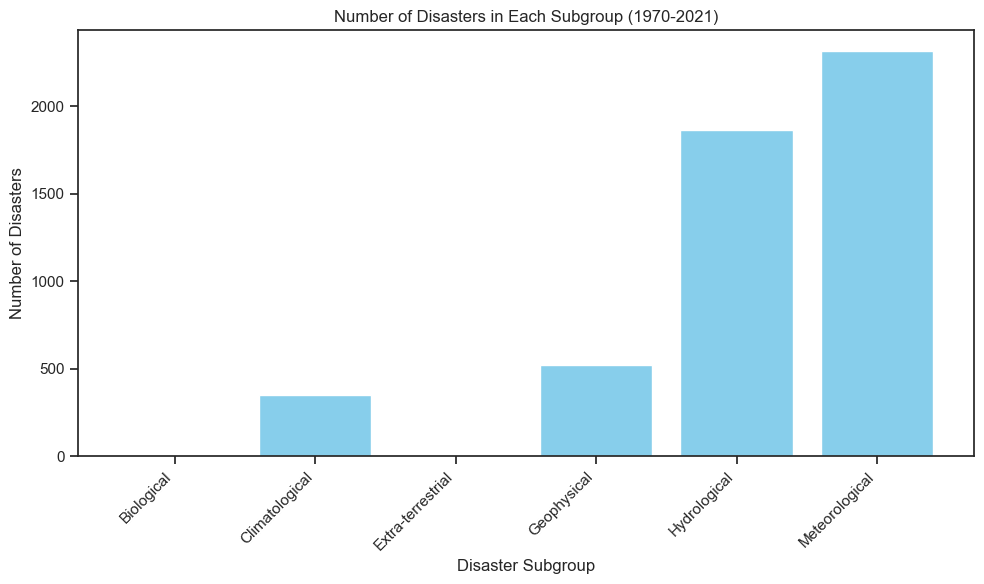

In [221]:
# Filter rows with non-null values in the specified columns
columns_to_check = ["Reconstruction Costs ('000 US$)", "Insured Damages ('000 US$)", "Total Damages ('000 US$)"]

# Retain rows where at least one of the specified columns is non-null
filtered_data_1970 = disasters_1970.data[disasters_1970.data[columns_to_check].notna().any(axis=1)]
print(filtered_data_1970.shape[0])  # Number of rows after filtering

# Group by the disaster subgroup and count the number of disasters
disaster_counts = filtered_data_1970.groupby("Disaster Subgroup").size().reset_index(name="Count")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(disaster_counts["Disaster Subgroup"], disaster_counts["Count"], color='skyblue')
plt.xlabel("Disaster Subgroup")
plt.ylabel("Number of Disasters")
plt.title("Number of Disasters in Each Subgroup (1970-2021)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

5435


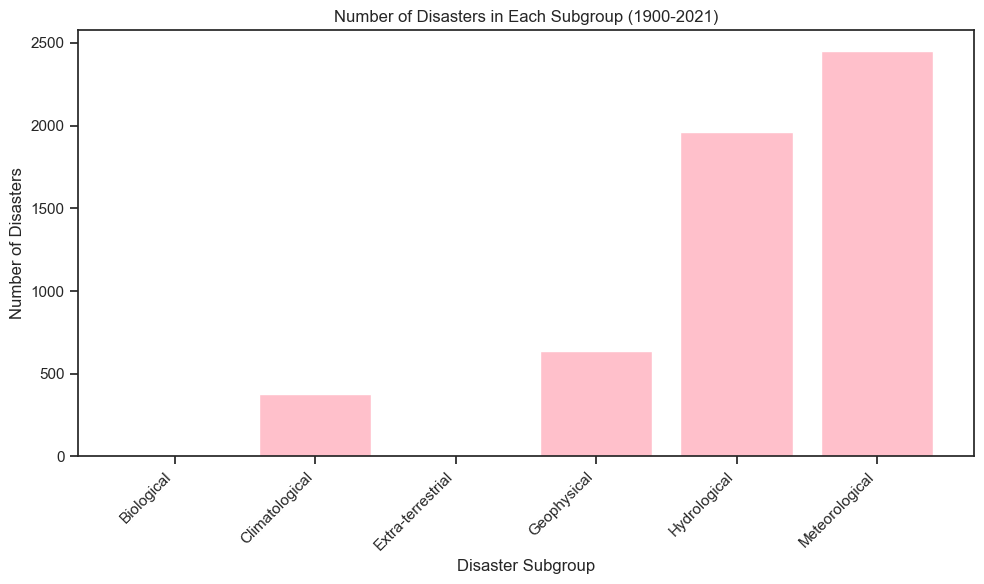

In [222]:
# Filter rows with non-null values in the specified columns
columns_to_check = ["Insured Damages ('000 US$)", "Total Damages ('000 US$)"]

# Retain rows where at least one of the specified columns is non-null
filtered_data_1900 = disasters_1900.data[disasters_1900.data[columns_to_check].notna().any(axis=1)]
print(filtered_data_1900.shape[0])  # Number of rows after filtering

# Group by the disaster subgroup and count the number of disasters
disaster_counts = filtered_data_1900.groupby("Disaster Subgroup").size().reset_index(name="Count")

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(disaster_counts["Disaster Subgroup"], disaster_counts["Count"], color='pink')
plt.xlabel("Disaster Subgroup")
plt.ylabel("Number of Disasters")
plt.title("Number of Disasters in Each Subgroup (1900-2021)")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [226]:
def plot_ndisasters_subgroup_per_year(filtered_data, title_years):
    # Group by year and subgroup, counting the number of disasters
    grouped_data = (
        filtered_data.groupby(["Year", "Disaster Subgroup"])
        .size()
        .reset_index(name="Count")
    )

    # Pivot the data to get subgroups as columns
    pivot_data = grouped_data.pivot(index="Year", columns="Disaster Subgroup", values="Count").fillna(0)


    plt.figure(figsize=(14, 8))

    pivot_data.plot(kind="bar", stacked=True, figsize=(14, 8), color=["pink", "purple", "skyblue", "orange", "green", "red"])

    # Add labels and title
    plt.xlabel("Year")
    plt.ylabel("Number of Disasters")
    plt.title(f"Number of Disasters Per Year by Subgroup ({title_years})")
    plt.legend(title="Disaster Subgroup", bbox_to_anchor=(1.05, 1), loc="upper left")

    ax = plt.gca()
    years = pivot_data.index
    ax.set_xticks(range(len(years)))  # Set the ticks to correspond to the years
    ax.set_xticklabels(
        [str(year) if i % 5 == 0 else "" for i, year in enumerate(years)], rotation=45, ha="right"
    )  # Show only every 5th year

    plt.tight_layout()
    plt.show()

<Figure size 1400x800 with 0 Axes>

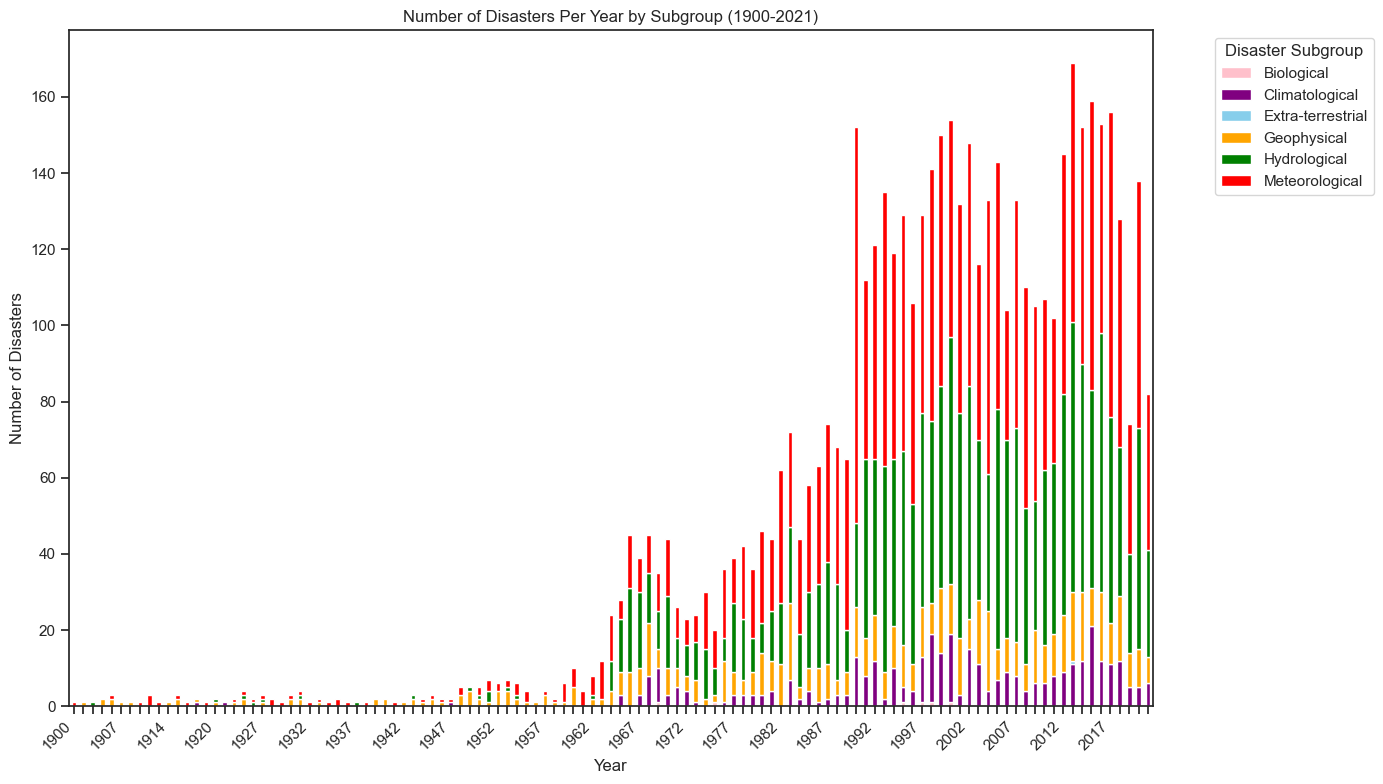

In [227]:
#Plot 1900s data per subgroup per year:
plot_ndisasters_subgroup_per_year(filtered_data_1900, "1900-2021")




<Figure size 1400x800 with 0 Axes>

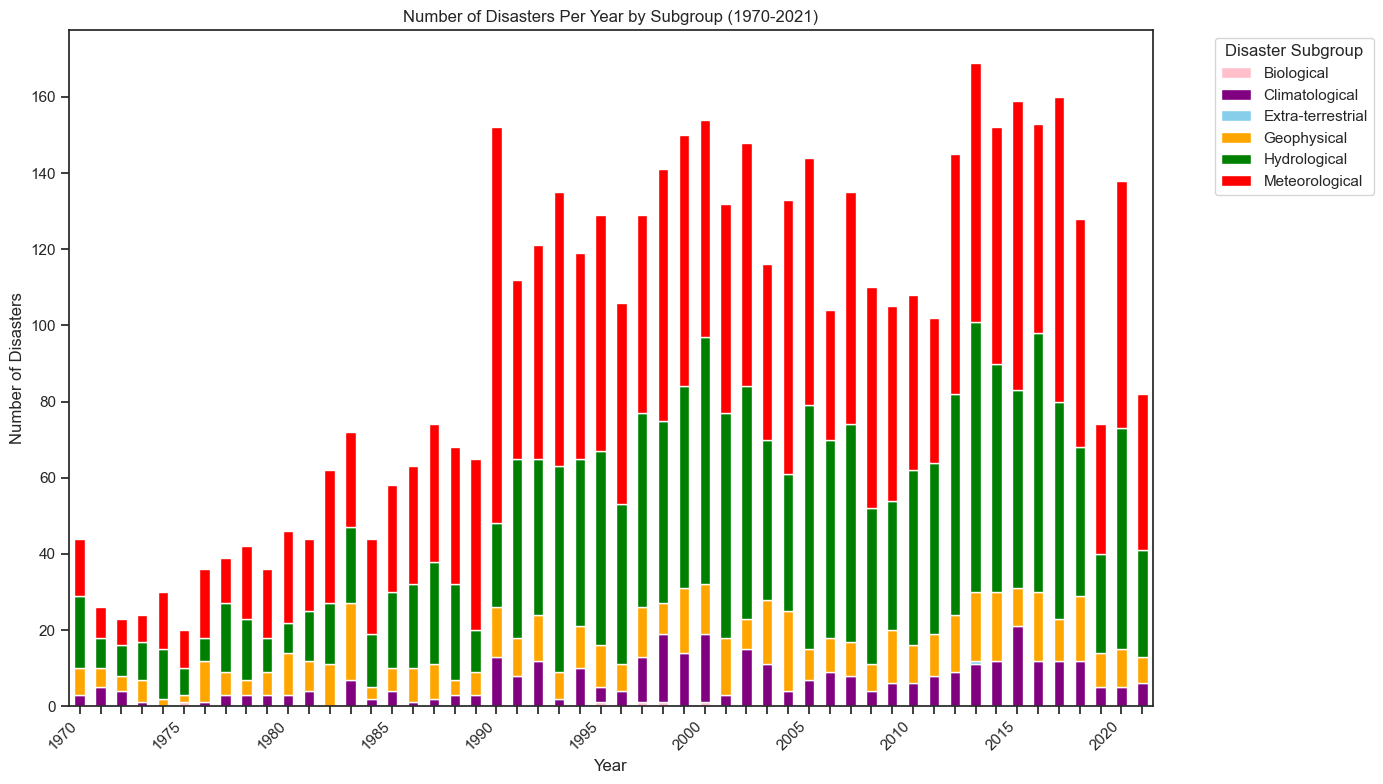

In [228]:
plot_ndisasters_subgroup_per_year(filtered_data_1970, "1970-2021")

For the above graphs, I have already filtered to only include values where the samples include monetary values for any damages. Shown below is the number of disasters for the given subgroups, in total:

In [237]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_disasters_per_year(df, year_column, filter_column, filter_values, title, x_label="Year", y_label="Number of Disasters"):
    # Filter the dataset based on specified values in a feature
    filtered_df = df[df[filter_column].isin(filter_values)]
    
    # Count the number of disasters per year
    disasters_per_year = filtered_df.groupby(year_column).size()
    
    # Initialize the figure
    plt.figure(figsize=(12, 6))
    sns.set_theme(style="ticks", font_scale=1)
    
    # Plot the data
    ax = sns.lineplot(x=disasters_per_year.index, y=disasters_per_year.values, marker="o", color="b")
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()


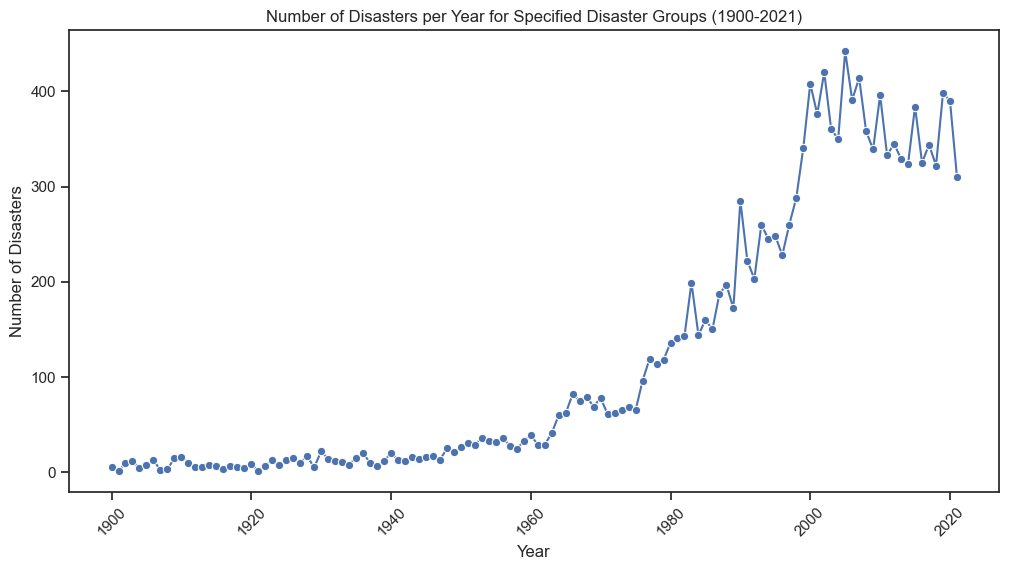

In [238]:
# Specify the values to filter for and call the function
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups or Types
plot_disasters_per_year(
    df=disasters_1900.df,
    year_column="Year",            # Replace with the correct column name for years in your dataset
    filter_column="Disaster Subgroup", # Column to filter (e.g., 'Disaster Group' or 'Disaster Type')
    filter_values=filter_values,
    title="Number of Disasters per Year for Specified Disaster Groups (1900-2021)"
)

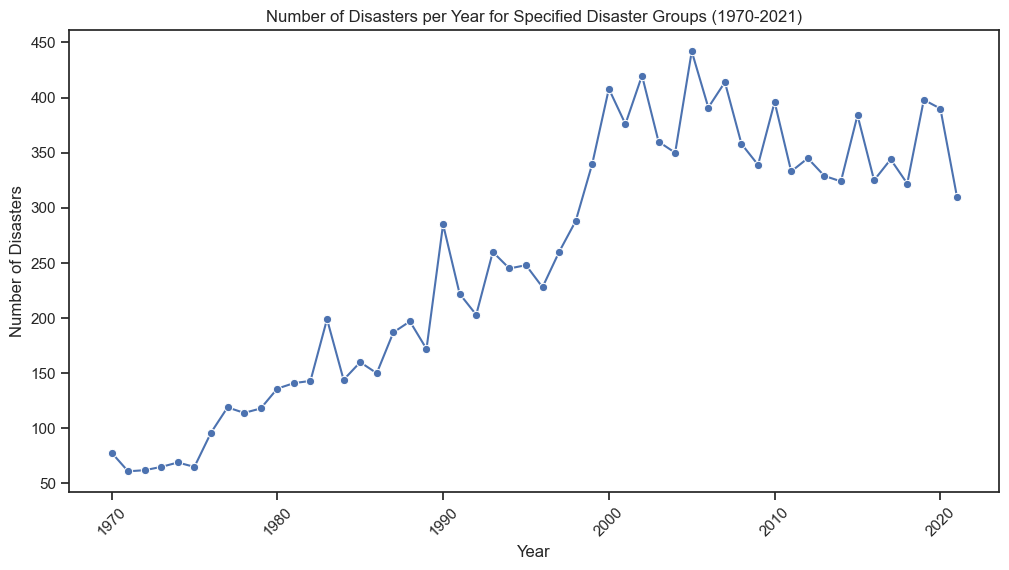

In [239]:
# Specify the values to filter for and call the function
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups or Types
plot_disasters_per_year(
    df=disasters_1970.df,
    year_column="Year",            # Replace with the correct column name for years in your dataset
    filter_column="Disaster Subgroup", # Column to filter (e.g., 'Disaster Group' or 'Disaster Type')
    filter_values=filter_values,
    title="Number of Disasters per Year for Specified Disaster Groups (1970-2021)"
)

And here are the plots with the categories breakdown:

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disasters_histogram(df, year_column, feature_column, filter_column, filter_values, title, x_label="Year", y_label="Number of Disasters"):
    # Filter the dataset based on specified values in a feature
    filtered_df = df[df[filter_column].isin(filter_values)]
    
    # Initialize the figure
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="ticks", font_scale=1)
    
    # Create a histogram with hue to differentiate between feature categories
    ax = sns.histplot(
        data=filtered_df,
        x=year_column,
        hue=feature_column,
        multiple="stack",  # Stacks the bars for each category within the year
        palette="Set1",    # Selects a color palette for different categories
        binwidth=1         # Bin width of 1 to get each year as a separate bin
    )
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()



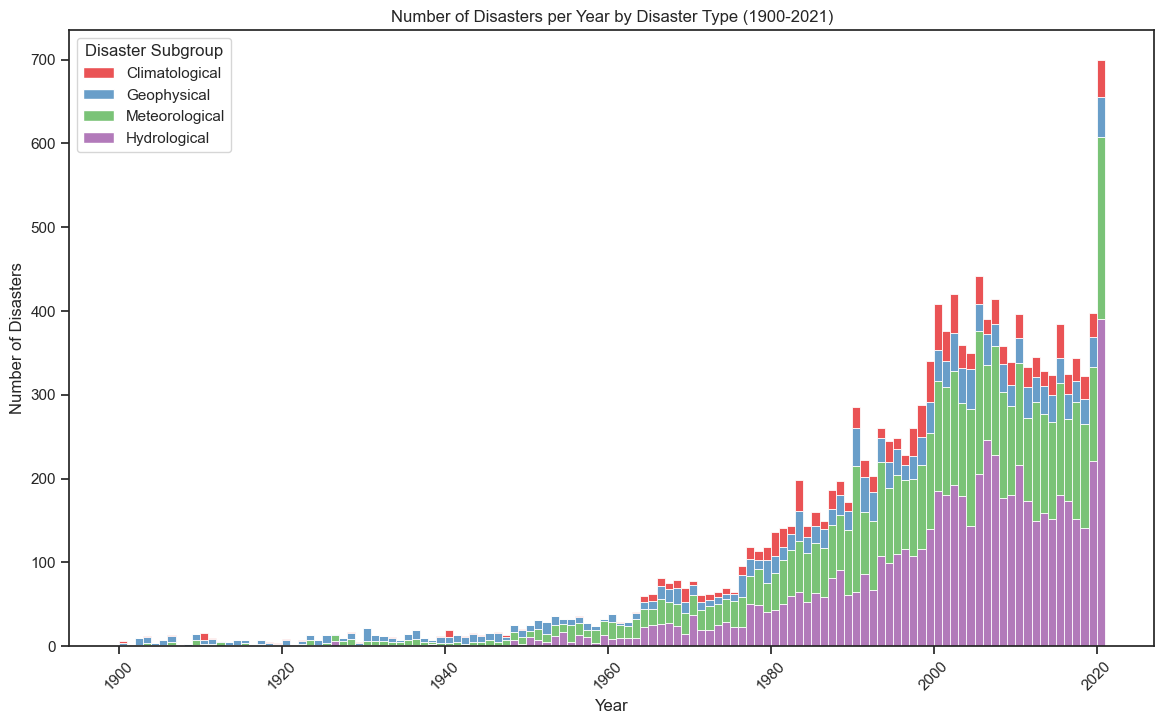

In [241]:
# Specify the values to filter for and call the function
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups or Types
plot_disasters_histogram(
    df=disasters_1900.data,
    year_column="Year",           # Replace with the correct column name for years in your dataset
    feature_column="Disaster Subgroup", # The feature to use for coloring (e.g., 'Disaster Type')
    filter_column="Disaster Subgroup", # Column to filter (e.g., 'Disaster Group')
    filter_values=filter_values,
    title="Number of Disasters per Year by Disaster Type (1900-2021)"
)

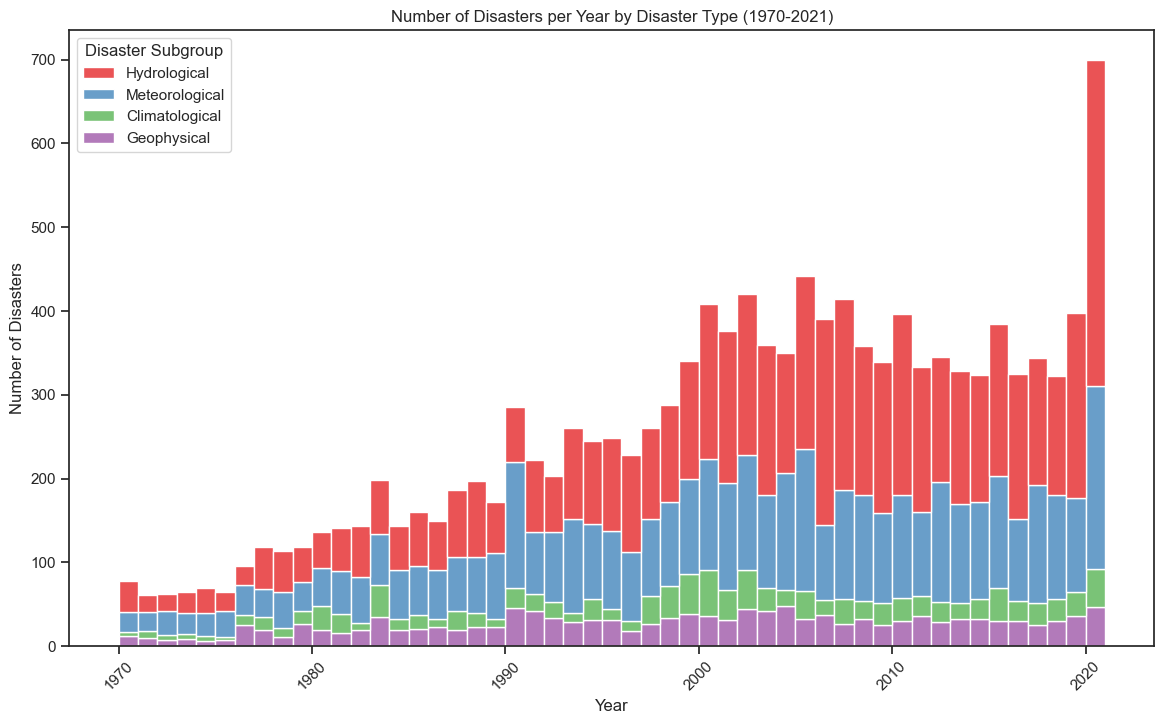

In [242]:
# Specify the values to filter for and call the function
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups or Types
plot_disasters_histogram(
    df=disasters_1970.data,
    year_column="Year",           # Replace with the correct column name for years in your dataset
    feature_column="Disaster Subgroup", # The feature to use for coloring (e.g., 'Disaster Type')
    filter_column="Disaster Subgroup", # Column to filter (e.g., 'Disaster Group')
    filter_values=filter_values,
    title="Number of Disasters per Year by Disaster Type (1970-2021)"
)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disasters_histogram(df, year_column, feature_column, filter_column, filter_values, title, x_label="Year", y_label="Number of Disasters"):
    # Filter the dataset based on specified values in a feature
    filtered_df = df[df[filter_column].isin(filter_values)]
    
    # Initialize the figure
    plt.figure(figsize=(14, 8))
    sns.set_theme(style="ticks", font_scale=1)
    
    # Create a histogram with hue to differentiate between feature categories
    ax = sns.histplot(
        data=filtered_df,
        x=year_column,
        hue=feature_column,
        multiple="stack",  # Stacks the bars for each category within the year
        palette="Set1",    # Selects a color palette for different categories
        binwidth=1         # Bin width of 1 to get each year as a separate bin
    )
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()

# Specify the values to filter for and call the function
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups or Types
plot_disasters_histogram(
    df=disasters.data,
    year_column="Year",           # Replace with the correct column name for years in your dataset
    feature_column="Disaster Subgroup", # The feature to use for coloring (e.g., 'Disaster Type')
    filter_column="Disaster Subgroup", # Column to filter (e.g., 'Disaster Group')
    filter_values=filter_values,
    title="Number of Disasters per Year by Disaster Type"
)

# Specify the values to filter for and call the function



Text(0.5, 1.0, 'Number of Disasters per Country (1970-2021)')

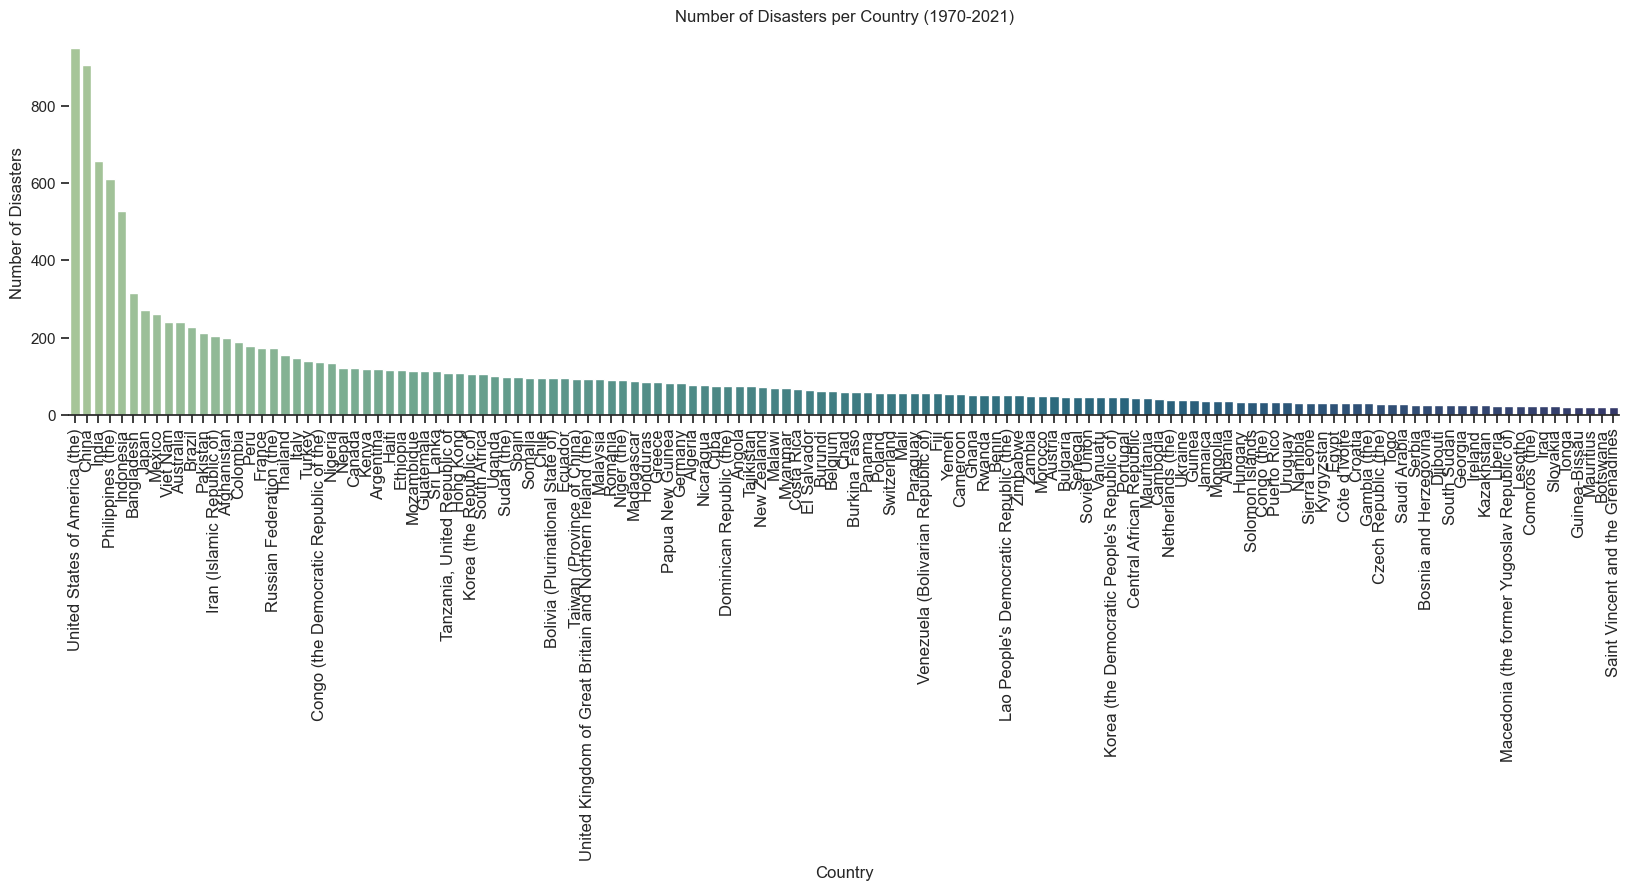

In [232]:
country_counts = disasters_1970.data['Country'].value_counts()
country_counts = country_counts[country_counts >20]

title='Number of Disasters per Country (1970-2021)'
x_label='Country'
y_label="Number of Disasters"
figsize=(20, 5)

# initialize the figure, set the tick information, and update the spines
plt.figure(figsize=figsize)
sns.set_theme(style="ticks", font_scale=1)
plt.xticks(rotation=90, fontsize=12)
sns.despine(top=True, right=True, bottom=False, left=True)

# plot the data
ax = sns.barplot(x=country_counts.index, y=country_counts.values, palette="crest", hue= country_counts.index, legend=False)

# set the x-label, y-label, and title
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.title(title)

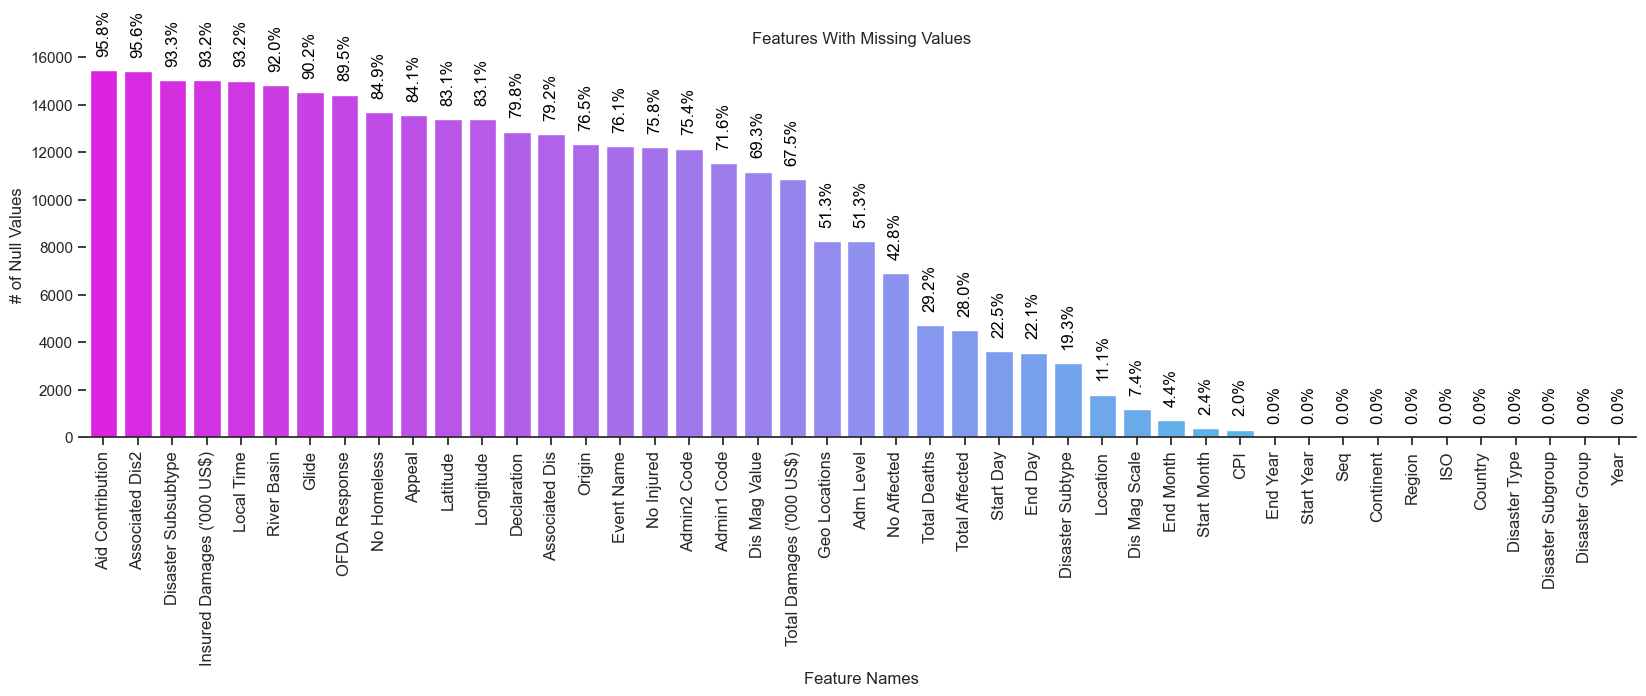

In [230]:
def plot_null_columns(
    df,
    title,
    x_label="Feature Names",
    y_label="# of Null Values",
    figsize=(20, 5)
):
    # count the number of times a given column has a null value
    null_cols = df.isnull().sum().sort_values(ascending=False)
    
    # initialize the figure, set the tick information, and update the spines
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    plt.xticks(rotation=90, fontsize=12)
    sns.despine(top=True, right=True, bottom=False, left=True)

    # plot the data
    ax = sns.barplot(x=null_cols.index, y=null_cols, palette="cool_r", hue=null_cols.index, legend=False)

    # set the x-label, y-label, and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)

    # loop over the patches and null column counts
    for (p, count) in zip(ax.patches, null_cols):
        # compute the percentage of the number of rows that have a null value
        # for the current column
        ax.annotate(
            "{:.1f}%".format((count / df.shape[0]) * 100),
            (p.get_x() + (p.get_width() / 2.0), abs(p.get_height())),
            ha="center",
            va="bottom",
            rotation="vertical",
            color="black",
            xytext=(0, 10),
            textcoords="offset points"
        )

# plot the null column counts within the dataset
plot_null_columns(disasters_1900.df, "Features With Missing Values")


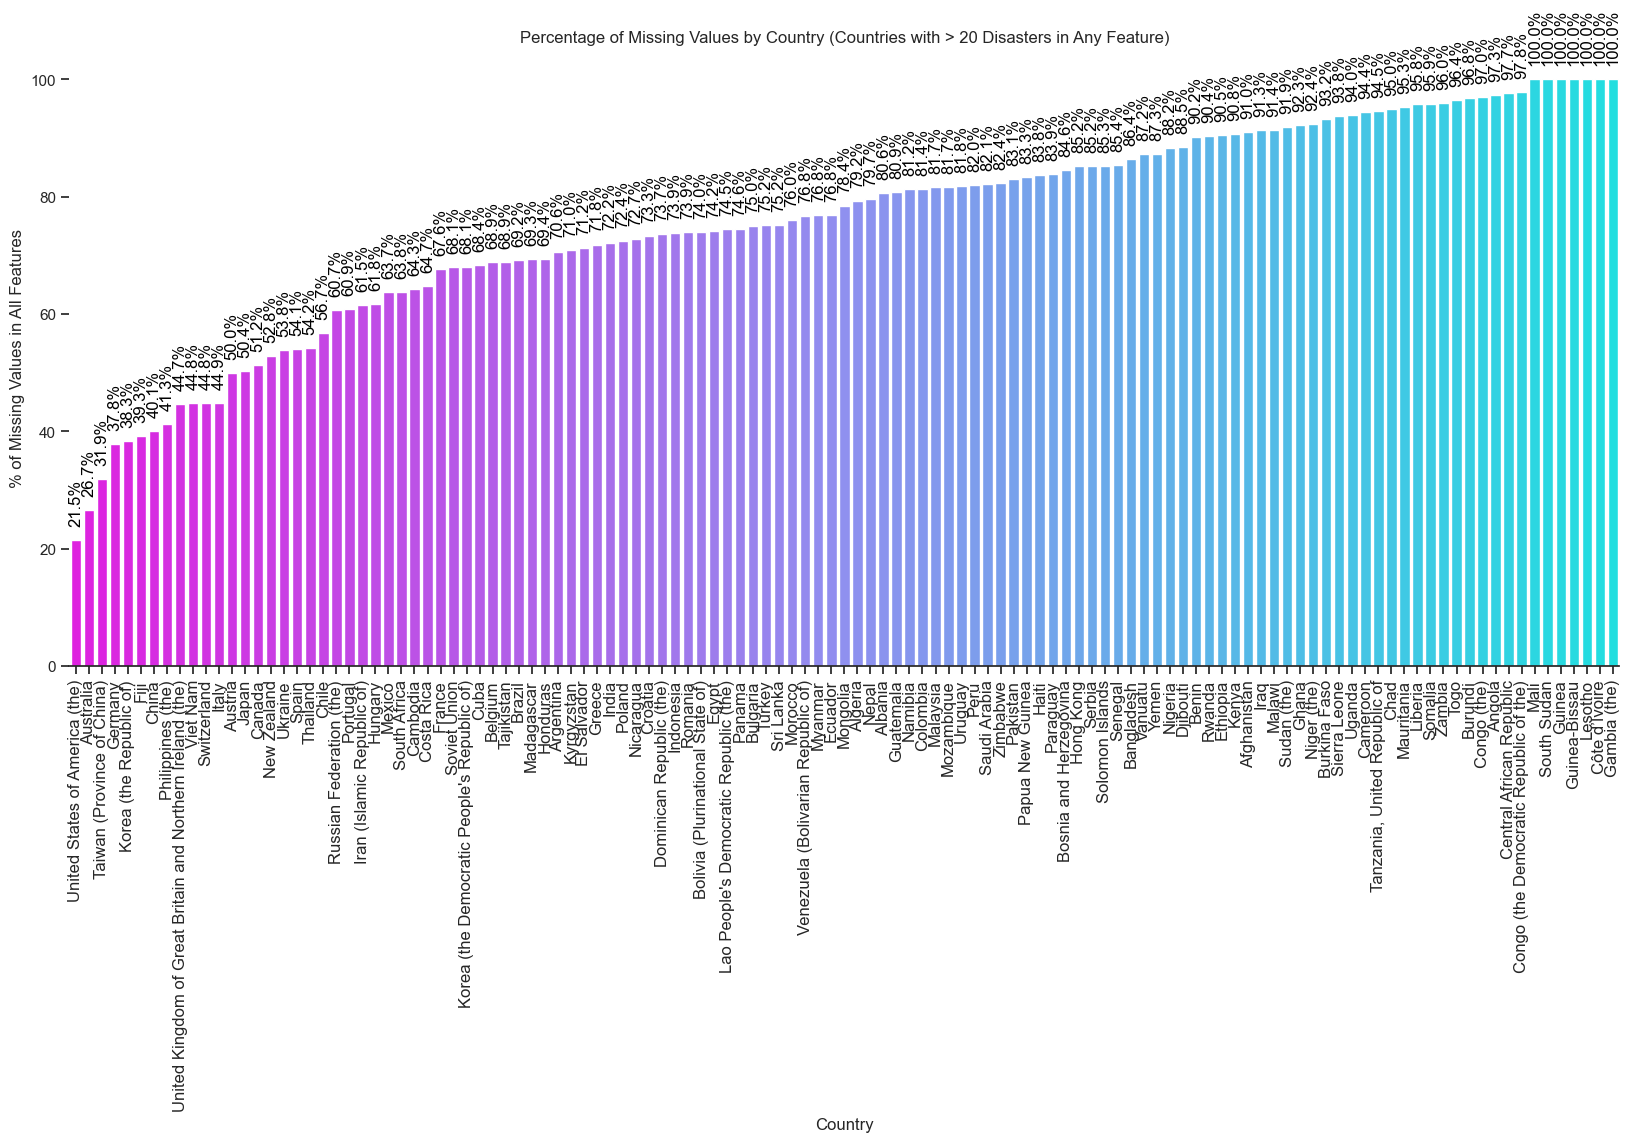

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values_by_country(df, features, title, x_label="Country", y_label="% of Missing Values in All Features", figsize=(20, 8), min_disasters=20):
    # Filter for countries with a minimum number of records that are missing in all specified features
    country_counts = df.groupby('Country').apply(
        lambda x: (x[features].isna().all(axis=1)).sum(),
        include_groups=False
    )
    countries_with_min_disasters = country_counts[country_counts > min_disasters].index
    filtered_df = df[df['Country'].isin(countries_with_min_disasters)]
    
    # Calculate the percentage of records missing in all specified features for each country
    missing_data = filtered_df.groupby('Country').apply(
        lambda x: (x[features].isna().all(axis=1)).mean() * 100,
        include_groups=False)
    
    # Sort by ascending order (least missing values in all features first)
    missing_data_sorted = missing_data.sort_values()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    plt.xticks(rotation=90, fontsize=12)
    sns.despine(top=True, right=True, bottom=False, left=True)
    
    # Plot the data
    ax = sns.barplot(x=missing_data_sorted.index, y=missing_data_sorted.values, palette="cool_r", hue=missing_data_sorted.index, legend=False)
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    # Annotate each bar with the percentage of missing values
    for (p, perc) in zip(ax.patches, missing_data_sorted):
        ax.annotate(
            "{:.1f}%".format(perc),
            (p.get_x() + (p.get_width() / 2.0), p.get_height()),
            ha="center",
            va="bottom",
            rotation="vertical",
            color="black",
            xytext=(0, 10),
            textcoords="offset points"
        )

plot_missing_values_by_country(
    disasters.data,
    features=["Total Damages ('000 US$)", "Reconstruction Costs ('000 US$)", "Insured Damages ('000 US$)"],
    title="Percentage of Missing Values by Country (Countries with > 20 Disasters in Any Feature)"
)


In [83]:
#Exclude anything not climate related:
#Geophysical
#Extra-terrestial
#Biological (can be argued that this should be included, but not as directly related to the climate, rather our population etc etc)


#Want to include:
#Meteorological, Hydrological, Climatological, 


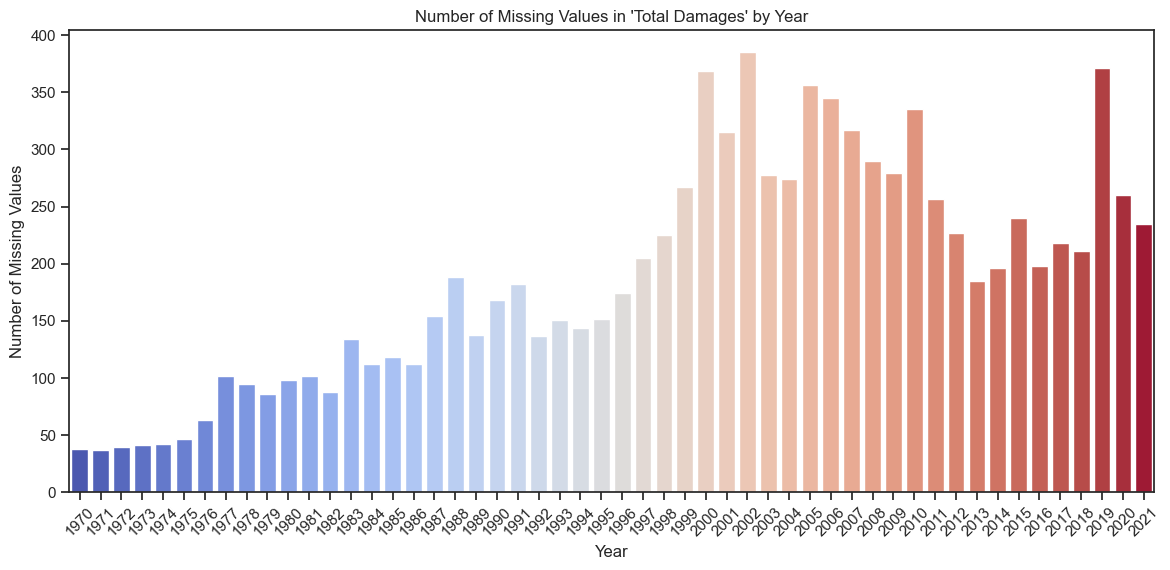

In [243]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_by_year(df, year_column, feature_column, title, x_label="Year", y_label="Number of Missing Values", figsize=(14, 6)):
    # Check for missing values in the specified feature
    df['Missing'] = df[feature_column].isna()
    
    # Group by year and sum the missing values for each year
    missing_by_year = df.groupby(year_column)['Missing'].sum()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    
    # Plot the missing values by year using a barplot or lineplot
    ax = sns.barplot(x=missing_by_year.index, y=missing_by_year.values, palette="coolwarm", hue=missing_by_year.index, legend=False)
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()

# Example: Plot missing values in the 'Total Damages' feature by year
plot_missing_by_year(
    df=disasters_1970.data,  # Your DataFrame
    year_column="Year", # The column for years
    feature_column="Total Damages ('000 US$)", # The feature for which you want to track missing values
    title="Number of Missing Values in 'Total Damages' by Year"
)


I want to check if any increase in damages recently are due to missing values in earlier years. But in fact we seemingly see an increase in missing values here for more modern disasters

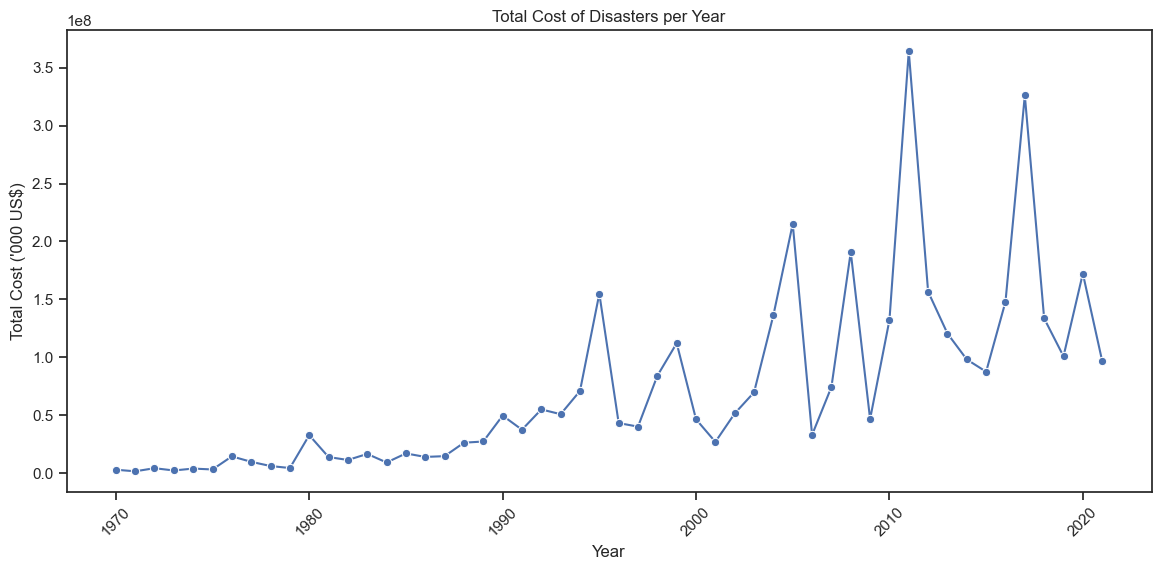

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cost_by_year(df, year_column, cost_column, filter_column, filter_values, title, x_label="Year", y_label="Total Cost ('000 US$)", figsize=(14, 6)):
    # Filter the dataset based on specified values in a feature
    filtered_df = df[df[filter_column].isin(filter_values)]
    
    # Aggregate the total cost of disasters per year
    cost_by_year = filtered_df.groupby(year_column)[cost_column].sum()
    
    # Initialize the figure
    plt.figure(figsize=figsize)
    sns.set_theme(style="ticks", font_scale=1)
    
    # Plot the total cost by year
    ax = sns.lineplot(x=cost_by_year.index, y=cost_by_year.values, marker="o", color="b")
    
    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.title(title)
    
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
filter_values = ["Geophysical", "Meteorological", "Hydrological", "Climatological"]  # Example filter for certain Disaster Groups
plot_cost_by_year(
    df=disasters.data,                   # Your DataFrame
    year_column="Year",                  # The column for years
    cost_column="Total Damages ('000 US$)", # The column containing the cost of disasters
    filter_column="Disaster Subgroup",      # The feature to filter (e.g., 'Disaster Group')
    filter_values=filter_values,         # The values to filter by
    title="Total Cost of Disasters per Year"
)
